# Исследование объявлений о продаже квартир

В проекте используется архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Стоит задача определить рыночную стоимость объектов недвижимости.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма.

### Загрузка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t' , decimal='.')

In [ ]:
pd.set_option('display.max_columns', 50)

In [ ]:
print(data.head(20))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20  13000000.0      108.00  2019-03-07T00:00:00      3   
1              7   3350000.0       40.40  2018-12-04T00:00:00      1   
2             10   5196000.0       56.00  2015-08-20T00:00:00      2   
3              0  64900000.0      159.00  2015-07-24T00:00:00      3   
4              2  10000000.0      100.00  2018-06-19T00:00:00      2   
5             10   2890000.0       30.40  2018-09-10T00:00:00      1   
6              6   3700000.0       37.30  2017-11-02T00:00:00      1   
7              5   7915000.0       71.60  2019-04-18T00:00:00      2   
8             20   2900000.0       33.16  2018-05-23T00:00:00      1   
9             18   5400000.0       61.00  2017-02-26T00:00:00      3   
10             5   5050000.0       39.60  2017-11-16T00:00:00      1   
11             9   3300000.0       44.00  2018-08-27T00:00:00      2   
12            10   3890000.0       54.00  2016-06-30T00:00:00   

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

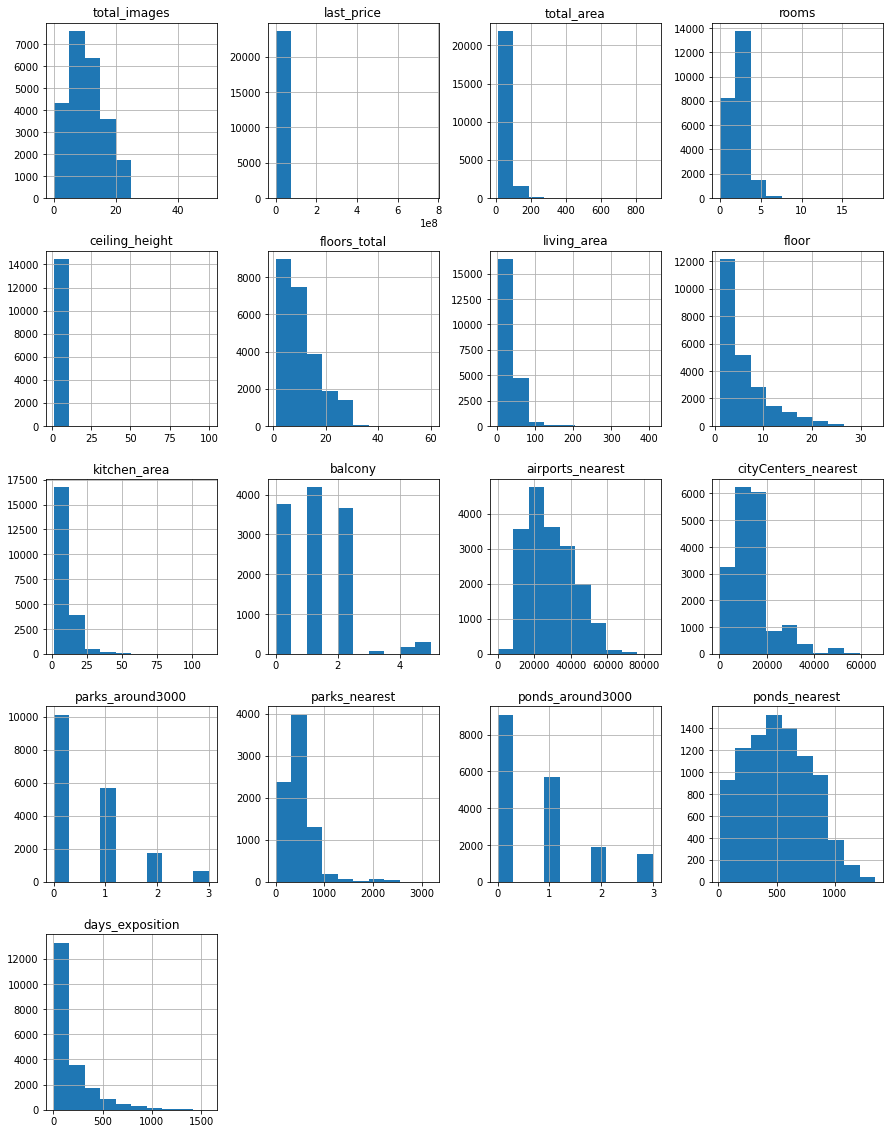

In [ ]:
data.hist(figsize=(15, 20))
None

Из графиков видно, что столбцы: last_price, total_area, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area - имеют выбросы или очень редкие значения.

### Предобработка данных

#### Переименуем столбцы

In [ ]:
data.rename(columns = {'studio':'is_studio', 'open_plan':'is_open_plan'}, inplace = True )

#### Изучим пропуски в данных

In [ ]:
def df_na_percent(df):
    temp_df = pd.DataFrame(df.isna().sum())
    temp_df.columns =  ['na_count']
    temp_df['na_percent'] = round(temp_df['na_count'] / len(data) * 100,0)
    print(temp_df)

In [ ]:
df_na_percent(data)

                      na_count  na_percent
total_images                 0         0.0
last_price                   0         0.0
total_area                   0         0.0
first_day_exposition         0         0.0
rooms                        0         0.0
ceiling_height            9195        39.0
floors_total                86         0.0
living_area               1903         8.0
floor                        0         0.0
is_apartment             20924        88.0
is_studio                    0         0.0
is_open_plan                 0         0.0
kitchen_area              2278        10.0
balcony                  11519        49.0
locality_name               49         0.0
airports_nearest          5542        23.0
cityCenters_nearest       5519        23.0
parks_around3000          5518        23.0
parks_nearest            15620        66.0
ponds_around3000          5518        23.0
ponds_nearest            14589        62.0
days_exposition           3181        13.0


In [ ]:
data['days_exposition'].describe()

count    20518.000000
mean       180.888634
std        219.727988
min          1.000000
25%         45.000000
50%         95.000000
75%        232.000000
max       1580.000000
Name: days_exposition, dtype: float64

#### Описание пропусков

Для некоторых пропусков имеет смысл использовать новый столбец `Класс жилья` - `flat_class`, который мы посчитаем далее.

`ceiling_height` - высота потолков, можно заполнить стандартным значением 2.7м или медианным в разрезе класса жилья

`floors_total` - Оставим пустым. (Заполнить сложно, можно попробовать найти точное совпадение по населенному пункту и расстоянием до центра и считать, что это одно здание. Не факт, что данные окажутся корректными.)

`living_area` - заполнить по формуле:
    
    - в разрезе класса жилья найти медианный Коэфициент жилой площади (Кжп =  отношение жилой площади к общей площади)
    - Кжп * общую площадь

`is_apartment`  - пропуски будем считать не апартаментами, заполним False

`kitchen_area` - заполнить по формуле:

    - в разрезе класса жилья найти медианный Коэфициент площади кухни (Кпк =  отношение площади кухни к общей площади)
    - Кпк * общую площадь

`balcony` - если не указано, заполним 0. Считаем, что нет балкона.

`locality_name` - заполнить нет возможности. пропусков 49. удалим данные


`airports_nearest`, `cityCenters_nearest` - расстояние в метрах. можно оставить пустыми, заполнить нулями или медианным значением для населенного пункта (кроме СПб)

`parks_nearest`, `ponds_nearest` - больше чем у 50% нет данных. может быть рядом нет парков. можно заполнить 0. Пока оставим пустыми.

`parks_around3000`, `ponds_around3000 `,  - кол-во в радиусе 3км. Из данных видно, что во многих местах где расстояние в метрах пропущено, в столбцах с количеством стоит 0. По аналогии заполним кол-во нулями.

`days_exposition` - сколько дней было размещено объявление. Оставим пропуски.

#### Заполнение пропусков

**Добавим столбец стоимости 1кв.м.** `m2_price`

In [ ]:
data['m2_price'] = data['last_price'] / data['total_area']

In [ ]:
#посмотрим на выбросы в новом столбце
data['m2_price'].describe()

count    2.369900e+04
mean     9.942166e+04
std      5.030680e+04
min      1.118349e+02
25%      7.658547e+04
50%      9.500000e+04
75%      1.142563e+05
max      1.907500e+06
Name: m2_price, dtype: float64

**Добавим столбец класс жилья** `flat_class`

- Эконом-класс - от 90 до 120 тыс. руб. за метр
- Комфорт-класс - от 120 до 180 тыс. руб за метр
- Бизнес-класс - от 180 до 300 тыс. руб за метр
- Премиум-класс и элитный - выше 300 тыс. руб за метр

Данные взяты для Санкт-Петербурга, источник: https://www.novostroy-spb.ru/statyi/klassy_kvartir_kak_otlichit, на 2019г.

In [ ]:
#создадим функцию для определения класса жилья
def categorize_flat_class(m2_price):
    try:
        if 0 <= m2_price < 120000:
            return 'Эконом-класс'
        elif 120000 <= m2_price < 180000:
            return 'Комфорт-класс'
        elif 180000 <= m2_price < 300000:
            return 'Бизнес-класс'
        elif m2_price >= 300000:
            return 'Премиум-класс и элитный'
    except:
        pass

In [ ]:
data['flat_class'] = data['m2_price'].apply(categorize_flat_class)

**Заполним высоту потолков медианой в зависимости от класса жилья**

In [ ]:
for flat_class in data['flat_class'].unique():
    median = data[data['flat_class'] == flat_class ]['ceiling_height'].median().round(1)
    data.loc[data['flat_class'] == flat_class, 'ceiling_height'] = data.loc[data['flat_class'] == flat_class, 'ceiling_height'].fillna(median)

**Заполним living_area (в зависимости от класса жилья)**

In [ ]:
for flat_class in data['flat_class'].unique():
    rows = (data['flat_class'] == flat_class)
    series = data.loc[rows,'living_area'] / data.loc[rows, 'total_area']
    medianK = series.median().round(4)
    data.loc[rows, 'living_area'] = data.loc[rows, 'living_area'].fillna(round(data['total_area'] * medianK, 2))

**Заполним kitchen_area (в зависимости от класса жилья)**

In [ ]:
for flat_class in data['flat_class'].unique():
    rows = (data['flat_class'] == flat_class)
    series = data.loc[rows,'kitchen_area'] / data.loc[rows, 'total_area']
    medianK = series.median().round(4)
    data.loc[rows, 'kitchen_area'] = data.loc[rows, 'kitchen_area'].fillna(round(data['total_area'] * medianK,2))

**Заполним остальные столбцы**

In [ ]:
data['is_apartment'] = data['is_apartment'].fillna('False')
data['balcony'] = data['balcony'].fillna(0)
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)

**Добавим  столбец площадь 1 комнаты**

In [ ]:
data['avg_room_area'] = data['living_area'] / data['rooms']

**Удалим записи с пропусками в населенном пункте**

In [ ]:
data = data.dropna(subset=['locality_name']).reset_index(drop=True)

In [ ]:
data = data.drop_duplicates().reset_index(drop=True)

In [ ]:
df_na_percent(data)

                      na_count  na_percent
total_images                 0         0.0
last_price                   0         0.0
total_area                   0         0.0
first_day_exposition         0         0.0
rooms                        0         0.0
ceiling_height               0         0.0
floors_total                85         0.0
living_area                  0         0.0
floor                        0         0.0
is_apartment                 0         0.0
is_studio                    0         0.0
is_open_plan                 0         0.0
kitchen_area                 0         0.0
balcony                      0         0.0
locality_name                0         0.0
airports_nearest          5534        23.0
cityCenters_nearest       5511        23.0
parks_around3000             0         0.0
parks_nearest            15586        66.0
ponds_around3000             0         0.0
ponds_nearest            14565        62.0
days_exposition           3180        13.0
m2_price   

#### Изменение типов данных

Изменим столбец `first_day_exposition` на дату. Это необходимо для создания новых столбцов `Год`, `Месяц`, `День недели`

`last_price` - поменяем на int, отбросим копейки

`is_apartment` - поменяем на bool

`balcony` - изменим на int, балкон не может быть дробным

`parks_around3000`, `ponds_around3000` - кол-во прудов и парков изменим на int, не может быть дробным


Столбцы с площадями: `total_area`, `living_area`, `kitchen_area` - оставим float, дробная часть имеет значение. каждый метр дорого стоит

In [ ]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')

In [ ]:
data['last_price'] = data['last_price'].astype('int')
data['is_apartment'] = data['is_apartment'].astype('bool')
data['balcony'] = data['balcony'].astype('int')
data['parks_around3000'] = data['parks_around3000'].astype('int')
data['ponds_around3000'] = data['ponds_around3000'].astype('int')

data['m2_price'] = data['m2_price'].astype(int)

In [ ]:
data.columns

Index(['total_images', 'last_price', 'total_area', 'first_day_exposition',
       'rooms', 'ceiling_height', 'floors_total', 'living_area', 'floor',
       'is_apartment', 'is_studio', 'is_open_plan', 'kitchen_area', 'balcony',
       'locality_name', 'airports_nearest', 'cityCenters_nearest',
       'parks_around3000', 'parks_nearest', 'ponds_around3000',
       'ponds_nearest', 'days_exposition', 'm2_price', 'flat_class',
       'avg_room_area'],
      dtype='object')

#### Удаление неявных дубликатов в населенных пунктах

In [ ]:
data['locality_name'].unique()

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

In [ ]:
len(data['locality_name'].unique())

364

**Напишем функцию для замены неявных дубликатов**

In [ ]:
def standartize_locality_name(locality_name):
    if type(locality_name) != type(''): return ''

    type_name = ''
    #Если название без типа населенного пункта и сразу с большой буквы - это город
    if locality_name[0].isupper():
        type_name = 'город'
    else:
        #Иначе произведем замены для стандартизации типов населенных пунктов
        map = {'посёлок': ['городской посёлок', 'поселок городского типа', 'поселок', 'посёлок', 'городской поселок', 'посёлок городского типа'],
                'поселок станции': ['поселок станции'],
                'деревня': ['деревня'],
                'снт': ['садоводческое некоммерческое товарищество', 'снт', 'садовое товарищество'],
                'село': ['село'],
                'город': ['город']
               }
        for key, value in map.items():
            for token in value:
                if token + ' ' in locality_name:
                    type_name = key
                    break

    #Если не удалось категоризовать, вернем тип населенного пункта из названия
    if type_name == '':
        words_list = locality_name.split()
        for word in words_list:
            if word[0].islower():
                type_name += word
            else:
                break

    #найдем название населенного пункта
    name = ''
    words_list = locality_name.split()
    for word in words_list:
        if word[0].isupper() or name != '': name += word + ' '

    return type_name + ' ' + name.rstrip()

In [ ]:
data['locality_name_standard'] = data['locality_name'].apply(standartize_locality_name)

In [ ]:
data['locality_name_standard'].unique()

array(['город Санкт-Петербург', 'посёлок Шушары', 'посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'город Ломоносов',
       'город Сертолово', 'город Петергоф', 'город Пушкин',
       'деревня Кудрово', 'город Коммунар', 'город Колпино',
       'посёлок Красный Бор', 'город Гатчина', 'деревня Фёдоровское',
       'город Выборг', 'город Кронштадт', 'город Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок Лебяжье', 'посёлок Сиверский', 'посёлок Молодцово',
       'посёлок Кузьмоловский', 'снт Новая Ропша', 'город Павловск',
       'деревня Пикколово', 'город Всеволожск', 'город Волхов',
       'город Кингисепп', 'город Приозерск', 'город Сестрорецк',
       'деревня Куттузи', 'посёлок Аннино', 'посёлок Ефимовский',
       'посёлок Плодовое', 'деревня Заклинье', 'посёлок Торковичи',
       'посёлок Первомайское', 'город Красное Село', 'посёлок Понтонный',
       'город Сясьстрой', 'деревня Старая', 'деревня Лесколово',
       'посёлок Нов

In [ ]:
len(data['locality_name_standard'].unique())

320

**Попробуем посчитать медианное расстояние до центра города и до аэропорта и заполнить пропуски**

In [ ]:
print(data[~data['airports_nearest'].isna()].head(20))

    total_images  last_price  total_area first_day_exposition  rooms  \
0             20    13000000       108.0           2019-03-07      3   
1              7     3350000        40.4           2018-12-04      1   
2             10     5196000        56.0           2015-08-20      2   
3              0    64900000       159.0           2015-07-24      3   
4              2    10000000       100.0           2018-06-19      2   
6              6     3700000        37.3           2017-11-02      1   
7              5     7915000        71.6           2019-04-18      2   
9             18     5400000        61.0           2017-02-26      3   
10             5     5050000        39.6           2017-11-16      1   
11             9     3300000        44.0           2018-08-27      2   
13            20     3550000        42.8           2017-07-01      2   
14             1     4400000        36.0           2016-06-23      1   
15            16     4650000        39.0           2017-11-18   

Из данных видно, что расстояние до центра - это расстояние из любого города до центра Санкт-Петербурга

Попробуем заполнить пропуски медианным значением расстояния до центра Санкт-Петербурга и до аэропорта в разрезе населенного пункта, но кроме СПб. По СПб каждый километр очень дорогой и заполнение медианным расстоянием приведет к большой погрешности.

In [ ]:
for locality_name in data['locality_name_standard'].unique():
    if locality_name == 'город Санкт-Петербург':
        continue

    rows = (data['locality_name_standard'] == locality_name)
    ser_airports_nearest = data.loc[rows, 'airports_nearest']
    ser_cityCenters_nearest = data.loc[rows, 'cityCenters_nearest']

    #проверка, чтобы исбежать предупреждений python'a когда весь датафрейм состоит из пропусков
    if len(ser_airports_nearest) != len(ser_airports_nearest[ser_airports_nearest.isna()]):
        median = ser_airports_nearest.median().round(0)
        data.loc[rows, 'airports_nearest'] = data.loc[rows, 'airports_nearest'].fillna(median)

    if len(ser_cityCenters_nearest) != len(ser_cityCenters_nearest[ser_cityCenters_nearest.isna()]):
        median = data.loc[rows, 'cityCenters_nearest'].median().round(0)
        data.loc[rows, 'cityCenters_nearest'] = data.loc[rows, 'cityCenters_nearest'].fillna(median)

In [ ]:
df_na_percent(data)

                        na_count  na_percent
total_images                   0         0.0
last_price                     0         0.0
total_area                     0         0.0
first_day_exposition           0         0.0
rooms                          0         0.0
ceiling_height                 0         0.0
floors_total                  85         0.0
living_area                    0         0.0
floor                          0         0.0
is_apartment                   0         0.0
is_studio                      0         0.0
is_open_plan                   0         0.0
kitchen_area                   0         0.0
balcony                        0         0.0
locality_name                  0         0.0
airports_nearest            4949        21.0
cityCenters_nearest         4925        21.0
parks_around3000               0         0.0
parks_nearest              15586        66.0
ponds_around3000               0         0.0
ponds_nearest              14565        62.0
days_expos

#### Устраняем аномалии

last_price, total_area, rooms, ceiling_height, floors_total, living_area, floor, kitchen_area

<AxesSubplot:>

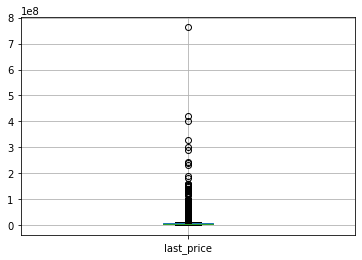

In [ ]:
data.boxplot(column='last_price')

<AxesSubplot:>

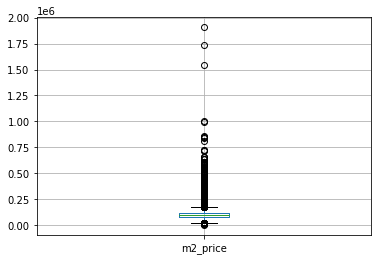

In [ ]:
data.boxplot(column='m2_price')

In [ ]:
total_rows = len(data)
def print_count_to_delete(co):
    print('Кол-во для удаления:', co)
    print('% к общему кол-ву записей:', round(co / total_rows * 100, 2))

In [ ]:
data['too_expensive'] = data['last_price'] > 30000000
co = data.query('too_expensive == True')['too_expensive'].count()
print_count_to_delete(co)

Кол-во для удаления: 316
% к общему кол-ву записей: 1.34


<AxesSubplot:>

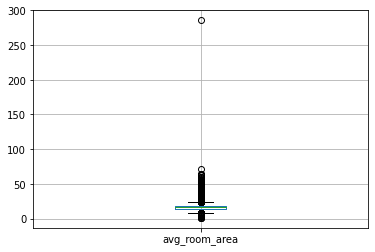

In [ ]:
data.boxplot(column='avg_room_area')

In [ ]:
data['too_small_room'] = data['avg_room_area'] < 5
co = data.query('too_small_room == True')['too_small_room'].count()
print_count_to_delete(co)

Кол-во для удаления: 13
% к общему кол-ву записей: 0.05


In [ ]:
data['too_big_room'] = data['avg_room_area'] > 80
co = data.query('too_big_room == True')['too_big_room'].count()
print_count_to_delete(co)

Кол-во для удаления: 198
% к общему кол-ву записей: 0.84


<AxesSubplot:>

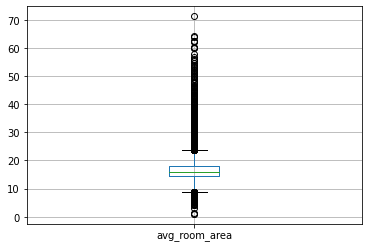

In [ ]:
data.query('too_big_room == False').boxplot(column='avg_room_area')

In [ ]:
round(data['avg_room_area'],1).describe()

count    23650.0
mean         inf
std          NaN
min          1.0
25%         14.4
50%         16.1
75%         18.2
max          inf
Name: avg_room_area, dtype: float64

Создадим новый столбец с ценой в миллионах для удобства

In [ ]:
data['last_price_mln'] = data['last_price'] / 1000000

<AxesSubplot:>

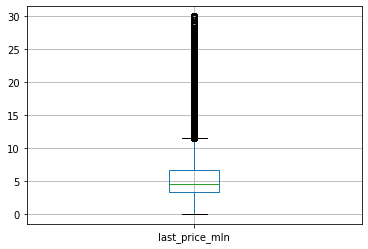

In [ ]:
data.query('too_expensive == False').boxplot(column='last_price_mln')

<AxesSubplot:>

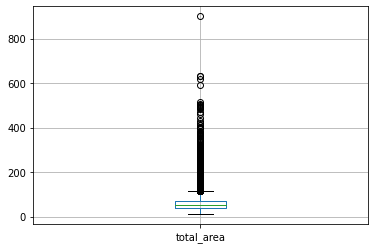

In [ ]:
data.boxplot(column='total_area')

In [ ]:
data['too_big_area'] = data['total_area'] > 150
co = data.query('too_big_area == True')['too_big_area'].count()
print_count_to_delete(co)

Кол-во для удаления: 562
% к общему кол-ву записей: 2.38


<AxesSubplot:>

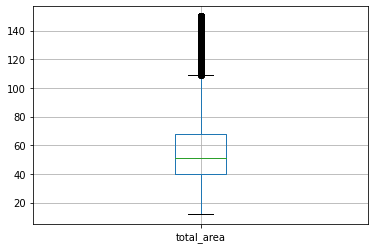

In [ ]:
data.query('too_big_area == False').boxplot(column='total_area')

<AxesSubplot:>

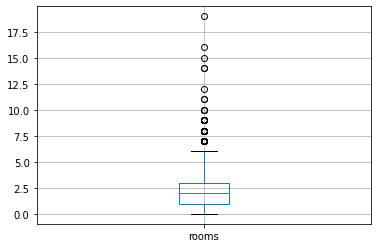

In [ ]:
data.boxplot(column='rooms')

In [ ]:
data['too_much_rooms'] = data['rooms'] > 8
co = data.query('too_much_rooms == True')['too_much_rooms'].count()
print_count_to_delete(co)

Кол-во для удаления: 19
% к общему кол-ву записей: 0.08


<AxesSubplot:>

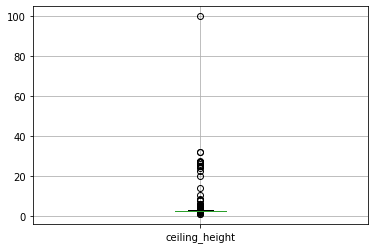

In [ ]:
data.boxplot(column='ceiling_height')

In [ ]:
data['too_height'] = data['ceiling_height'] > 5
co = data.query('too_height == True')['too_height'].count()
print_count_to_delete(co)

Кол-во для удаления: 36
% к общему кол-ву записей: 0.15


<AxesSubplot:>

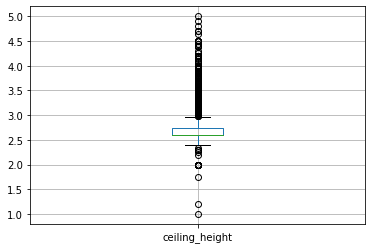

In [ ]:
data.query('too_height == False').boxplot(column='ceiling_height')

<AxesSubplot:>

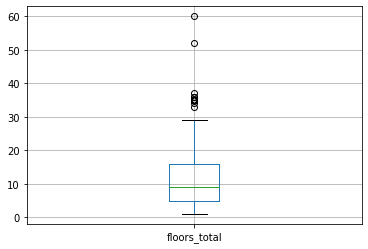

In [ ]:
data.boxplot(column='floors_total')

<AxesSubplot:>

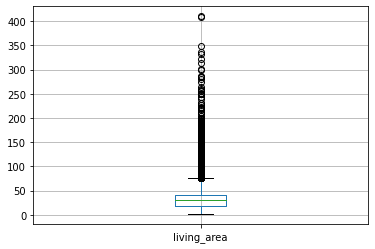

In [ ]:
data.boxplot(column='living_area')

<AxesSubplot:>

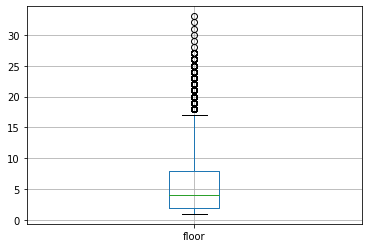

In [ ]:
data.boxplot(column='floor')

<AxesSubplot:>

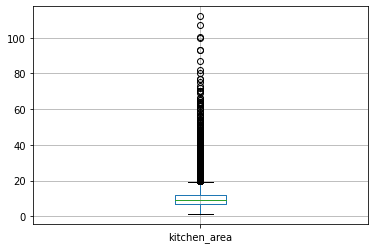

In [ ]:
data.boxplot(column='kitchen_area')

In [ ]:
data['too_big_kitchen'] = data['kitchen_area'] > 30
co = data.query('too_big_kitchen == True')['too_big_kitchen'].count()
print_count_to_delete(co)

Кол-во для удаления: 371
% к общему кол-ву записей: 1.57


#### Отрежем выбросы

In [ ]:
co = data.query('too_big_room == True or too_expensive == True or too_big_area == True or too_much_rooms == True or too_height == True or too_big_kitchen == True')['last_price'].count()
print_count_to_delete(co)

Кол-во для удаления: 1070
% к общему кол-ву записей: 4.52


всего 1070 записией или 4.52%, что является приемлемыми потерями

In [ ]:
data = (data
        .query('too_big_room == False and too_expensive == False and too_big_area == False and too_much_rooms == False and too_height == False and too_big_kitchen == False')
        .reset_index()
            )

**Вывод**
   
База данных была обработана, очищена от выбросов, устранены аномалии и пропущенные значения, так же были устранены неявные дубликаты в названиях населенных пунктах.
    
Всего были удалены 1070 записией или 4.52%, что является приемлемыми потерями.

### Посчитайте и добавьте в таблицу новые столбцы

Добавим день недели даты публикации объявления

In [ ]:
def weekday_russian_name(date):
    weekday = date.weekday()
    weekday_list = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']
    try:
        return weekday_list[weekday]
    except:
        pass

In [ ]:
data['day_of_week_exposition'] = data['first_day_exposition'].apply(weekday_russian_name)

Добавим год и месяц даты публикации объявления

In [ ]:
data['year_exposition'] = data['first_day_exposition'].dt.year
data['month_exposition'] = data['first_day_exposition'].dt.month

Добавим признак этажа Первый/Последний/Другой

In [ ]:
def f_floor_type(row):
    try:
        if row['floor'] == 1:
            return 'первый'
        elif row['floor'] == row['floors_total']:
            return 'последний'
        else:
            return 'другой'
    except:
        pass

data['floor_type'] = data.apply(f_floor_type, axis=1)

Добавим столбец расстояние в километрах до центра

In [ ]:
data['cityCenters_nearest_km'] = (data['cityCenters_nearest'] / 1000).round(0)

### Проведите исследовательский анализ данных

#### Изучим основные параметры

Построим гистограммы по основным параметрам:

        - общая площадь;
        - жилая площадь;
        - площадь кухни;
        - цена объекта;
        - количество комнат;
        - высота потолков;
        - этаж квартиры;
        - тип этажа квартиры («первый», «последний», «другой»);
        - общее количество этажей в доме;
        - расстояние до центра города в метрах;
        - расстояние до ближайшего аэропорта;
        - расстояние до ближайшего парка;
        - день и месяц публикации объявления

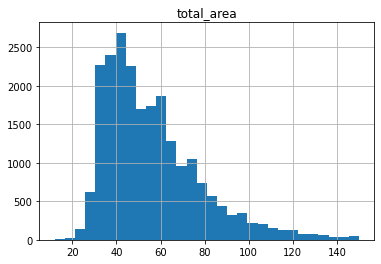

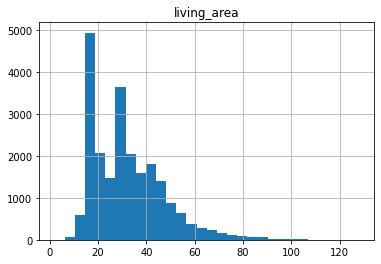

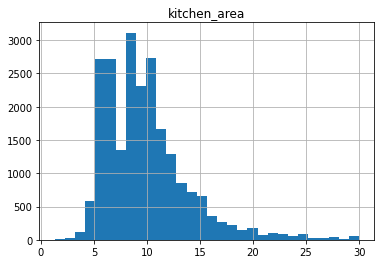

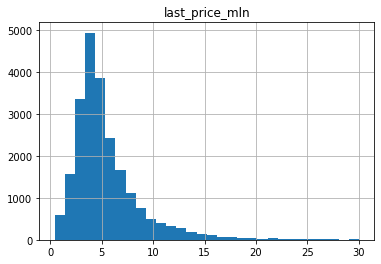

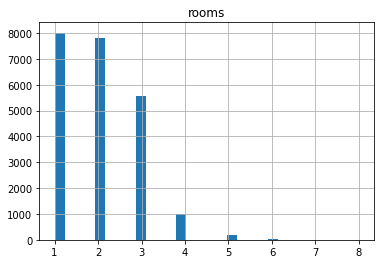

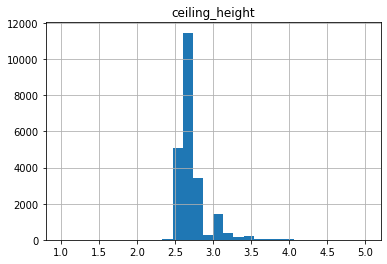

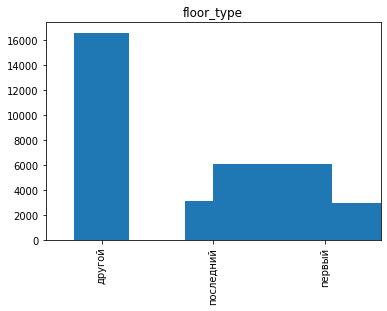

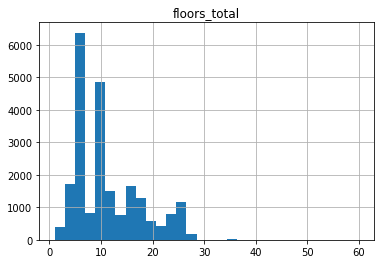

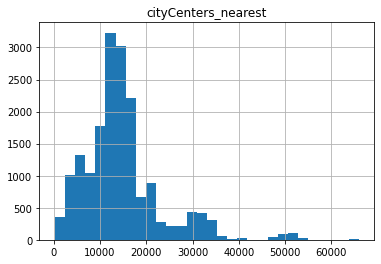

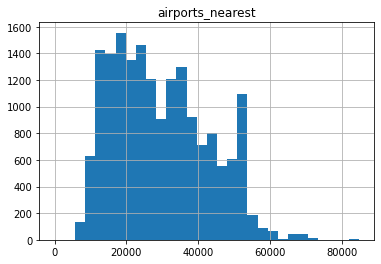

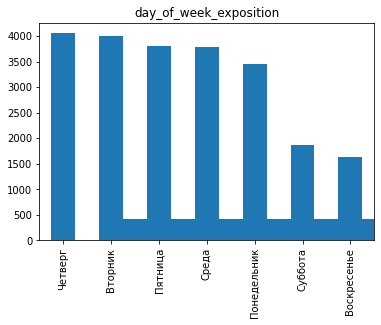

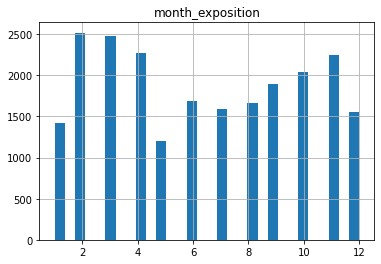

In [ ]:
columns = ['total_area', 'living_area', 'kitchen_area', 'last_price_mln', 'rooms', 'ceiling_height', 'floor', 'floor_type', 'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'day_of_week_exposition', 'month_exposition']

for col in columns:
    try:
        data.hist(column=col, bins=30)
    except ValueError:
        data[col].value_counts().plot(kind='bar', title=col)
        plt.show()

In [ ]:
data['last_price_mln'].describe()

count    22580.000000
mean         5.468320
std          3.470049
min          0.430000
25%          3.400000
50%          4.550000
75%          6.500000
max         30.000000
Name: last_price_mln, dtype: float64

In [ ]:
data['floor_type'].value_counts()/len(data)

другой       0.735474
последний    0.138485
первый       0.126041
Name: floor_type, dtype: float64

In [ ]:
data['floors_total'].value_counts()/len(data)

5.0     0.247431
9.0     0.164216
12.0    0.058370
16.0    0.058105
10.0    0.050221
4.0     0.049114
25.0    0.045704
17.0    0.035341
6.0     0.034721
3.0     0.027591
14.0    0.023649
7.0     0.022232
18.0    0.021213
24.0    0.019663
2.0     0.016209
15.0    0.015545
23.0    0.014925
19.0    0.014216
8.0     0.014172
22.0    0.012489
20.0    0.011027
13.0    0.009477
11.0    0.008326
27.0    0.007130
21.0    0.006599
26.0    0.005403
1.0     0.001107
35.0    0.000974
28.0    0.000930
36.0    0.000089
37.0    0.000044
34.0    0.000044
33.0    0.000044
60.0    0.000044
29.0    0.000044
52.0    0.000044
Name: floors_total, dtype: float64

**total_area** - общая площадь квартиры - имеет 1 пик в районе 40 кв.м.

**living_area** - жилая площадь - имеет 2 пика, 18 квм и 25 квм

**kitchen_area** - площадь кухни - так же имеет 2 пика: 5-6 квм и 8-10 квм.

**last_price_mln** - последняя стоимость в млн. руб - имеет пик 4.5 млн. руб., нормальное распределение,

Значения квантилей:

    25% - 3.4млн
    50% - 4.5млн
    75% - 6.5млн

**rooms** - кол-во комнат - 1 и 2 команты имеют максимальное кол-во объявлений, по около 8000 каждый. 3 место занимают 3х комнатные квартиры со значением около 5500 объявлений

**ceiling_height** - высота потолков - пик 2.7м в высоту, это значение ожидаемое, т.к. высота 2.7м является стандартом

**floor_type** - тип этажа - наибольшее кол-во у объявлений  у которых этаж "другой", первые и последние этажи имеют долю в 12% и 13% соответственно

**floors_total** - всего этажей в доме - дома пятиэтажки - 24%, дома девятиэтажки - 16 %. 99% домов имеют этажность до 30 этажей

**cityCenters_nearest** - расстояние в метрах до центра СПб - имеет пик 12-14 тыс. метров.

**airports_nearest** - расстояние до аэропорта - 90% объявлений имеют расстояние от 10 км до 55 км. Объаявления имеют практически равномерное распределение. Это объясняется тем, что застраивают не вокруг аэропорта аналогично центру города, а там где есть возможность. Аэропорты достраивают во 2 очередь при необходимости для оптимизации трафика, как это делается в Москве.

**day_of_week_exposition** - день недели создания объявления - из графика мы видим что объявления чаще создают в рабочие дни.
Распределение по дням неделям практически равномерно в группах рабочий день / выходной.

**month_exposition** - месяц создания объявления - из графика мы наблюдаем сезонность продаж. Наибольшая активность в начале весны и в середине осени. Лето и Зима затишье. Летом сезон отпусков. Зимой сезон праздников, а так же может иметь влияние погоды на трафик в городе, который влияет на желание людей ездить искать хорошие предложения.

#### Изучим  скорость продажи квартир

<AxesSubplot:>

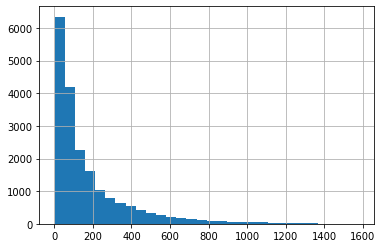

In [ ]:
good_data = data.query('days_exposition.isna() == False')
good_data['days_exposition'].hist(bins = 30)

In [ ]:
good_data['days_exposition'].describe()

count    19640.000000
mean       177.603360
std        215.856345
min          1.000000
25%         45.000000
50%         94.000000
75%        226.000000
max       1580.000000
Name: days_exposition, dtype: float64

**Вывод**

Среднее арифметическое кол-во дней для продажи квартиры - 177 дней

Значение медианы кол-ва дней продажи квартиры - 94 дней. Медиана почти в 2 раза отличается от среднего арифметического значения. Это говорит о том, что доля долгих объявлений существенная. Из статистического описания данных видно, что продажи более 226 дней имеют 25%.

Для недвижимости в СПб быстрыми продажами считаются продажи до 45 дней и долгими  свыше 226 дней.

#### Изучим зависимость цены объекта от параметров

Параметры:
    
  - общая площади;
  - жилая площади;
  - площадь кухни;
  - количество комнат;
  - тип этажа, на котором расположена квартира (первый, последний, другой);
  - дата размещения (день недели, месяц, год);

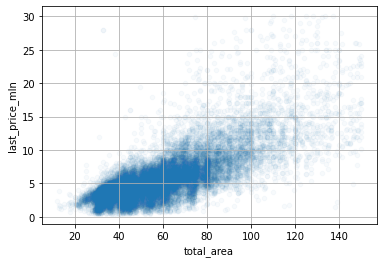

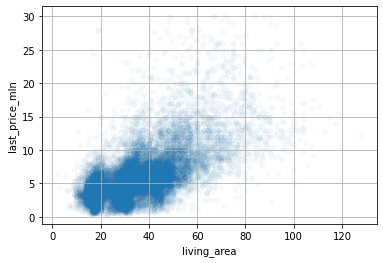

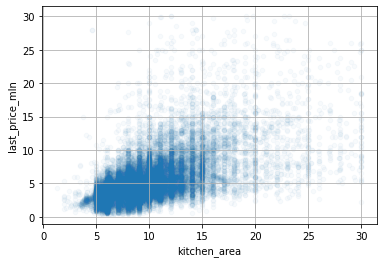

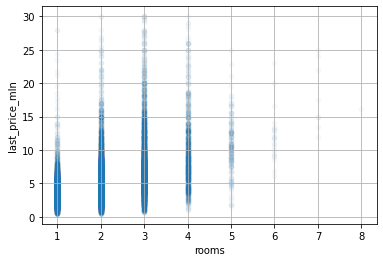

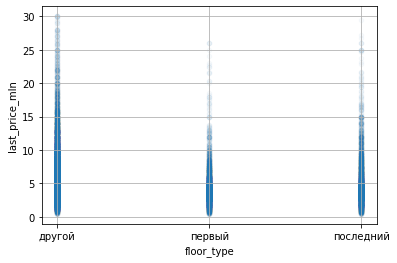

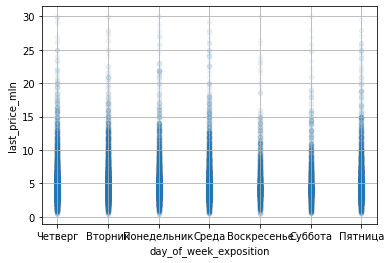

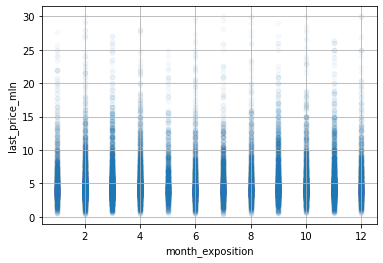

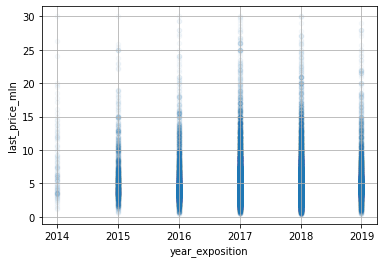

In [ ]:
columns = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'floor_type', 'day_of_week_exposition', 'month_exposition', 'year_exposition']

for col in columns:
    data.plot(x=col, y='last_price_mln', kind='scatter', alpha=0.03, grid=True)
    plt.show

In [ ]:
data[columns].corrwith(data['last_price_mln'])

total_area          0.751305
living_area         0.641433
kitchen_area        0.577597
rooms               0.461324
month_exposition    0.005854
year_exposition    -0.019314
dtype: float64

In [ ]:
data[columns].corrwith(data['m2_price'])

total_area          0.127354
living_area         0.033475
kitchen_area        0.308339
rooms              -0.089933
month_exposition   -0.004609
year_exposition     0.052104
dtype: float64

**Вывод**

**Общая площадь** имеет самую большую положительную корреляцию. 0.75. Чем больше общая площадь квартиры тем дороже. Но из графика видно, что для сверх дорогих квартир эта корреляция пропадает. Элитное жилье это штучный товар, для которого цена устанавливается индивидуально.

**Жилая площадь и площадь кухни** так же имеют большее влияние. Это второстепенные параметры и они почти линейно коррелируются с общей площадью. Отметим, что площадь кухни имеет влияние на стоимость 1 кв м. Чем больше кухня, тем дороже 1 кв. м.

**Число комнат** так же имеет положительную корреляцию, но для больших квартир с большим кол-вом комнат эта зависимость снижается.
Корреляция отчетливо прослеживается на стандартных квартирах до 3 комнат.

**Год, месяц и день недели** не влияют на цену. Всегда продаются квартиры из любого сегмента по стоимости.
Стоит уточнить, что стоимость 1кв м жилья имеет слабый положительный тренд к росту в зависимости от года. Каждый год стоимость 1 кв м квартиры растет.

**Первые и последние этажи** в среднем продаются дешевле, чем квартиры на других этажах

#### Изучим средний цену 1 кв. м. в 10 населенных пунктах с наибольшим  кол-вом объявлений

In [ ]:
data_top_locality = data.pivot_table(index='locality_name_standard', values='locality_name', aggfunc=['count'])
data_top_locality.columns = ['count']
data_top_locality = data_top_locality.sort_values(by='count', ascending=False).head(10)
data_top_locality

,count
locality_name_standard,
город Санкт-Петербург,14803
посёлок Мурино,527
посёлок Шушары,434
город Всеволожск,390
город Пушкин,354
город Колпино,337
посёлок Парголово,322
город Гатчина,305
деревня Кудрово,282


In [ ]:
good_data = data.query('locality_name_standard in @data_top_locality.index')
good_data_pivot = good_data.pivot_table(index='locality_name_standard', values=['m2_price'], aggfunc=['min', 'max','count'])
good_data_pivot.columns = ['min_m2_price', 'max_m2_price', 'count']
good_data_pivot.sort_values(by='count', ascending=False)

,min_m2_price,max_m2_price,count
locality_name_standard,,,
город Санкт-Петербург,15345,848484,14803
посёлок Мурино,50000,138580,527
посёлок Шушары,47700,134000,434
город Всеволожск,31400,640422,390
город Пушкин,59836,256521,354
город Колпино,47957,125000,337
посёлок Парголово,48405,138522,322
город Гатчина,10507,146315,305
деревня Кудрово,54160,142857,282


(0.0, 200000.0)

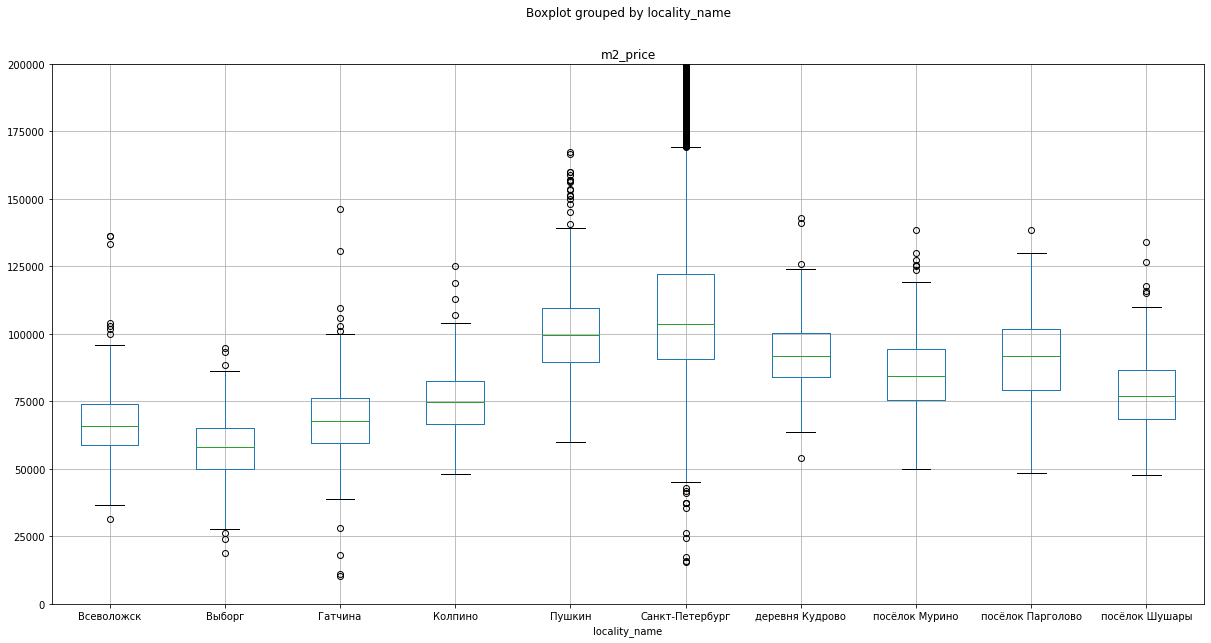

In [ ]:
top_locality = data['locality_name'].value_counts().sort_values(ascending=False).head(10)

ax = (data
    .query('locality_name in @top_locality.index')
    .boxplot('m2_price', by='locality_name', figsize=(20, 10))
)
ax.set_ylim(0, 200000)

In [ ]:
good_data.query('locality_name_standard == "город Санкт-Петербург"')['total_area'].max()

150.0

In [ ]:
good_data.query('m2_price == 848484')[['locality_name_standard', 'last_price', 'total_area', 'cityCenters_nearest']]

,locality_name_standard,last_price,total_area,cityCenters_nearest
4615,город Санкт-Петербург,28000000,33.0,1376.0
16357,город Санкт-Петербург,28000000,33.0,1462.0


In [ ]:
good_data.query('m2_price == 640422')

,index,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,...,last_price_mln,too_big_area,too_much_rooms,too_height,too_big_kitchen,day_of_week_exposition,year_exposition,month_exposition,floor_type,cityCenters_nearest_km
20229,21197,1,24412900,38.12,2018-06-27,1,3.2,10.0,16.83,4,...,24.4129,False,False,False,False,Среда,2018,6,другой,NaN


In [ ]:
good_data_pivot.query('min_m2_price > 20000')['min_m2_price'].mean()

48494.0

In [ ]:
good_data_pivot.query('max_m2_price < 600000')['max_m2_price'].mean()

147075.0

Для каждого населенного пункта опишем статистические данные стоимости 1 кв. метра

In [ ]:
good_data.groupby('locality_name_standard')['m2_price'].describe()

,count,mean,std,min,25%,50%,75%,max
locality_name_standard,,,,,,,,
город Всеволожск,390.0,68625.953846,31735.299690,31400.0,58910.75,65789.0,73993.00,640422.0
город Выборг,234.0,57984.726496,12149.083216,18750.0,50000.00,58133.0,64978.00,94805.0
город Гатчина,305.0,68687.347541,14660.911672,10507.0,59770.00,67796.0,76136.00,146315.0
город Колпино,337.0,75332.866469,11956.020232,47957.0,66666.00,74722.0,82547.00,125000.0
город Пушкин,354.0,102509.225989,20714.084072,59836.0,89709.00,99678.0,109635.25,256521.0
город Санкт-Петербург,14803.0,109959.747281,31255.627051,15345.0,90618.00,103750.0,122119.00,848484.0
деревня Кудрово,282.0,92368.723404,12516.150049,54160.0,84158.00,91666.0,100264.00,142857.0
посёлок Мурино,527.0,85038.244782,14337.615071,50000.0,75304.00,84239.0,94351.00,138580.0
посёлок Парголово,322.0,90448.000000,17039.820007,48405.0,79085.25,91984.0,101833.50,138522.0


**Вывод**

**Минимальная цена** 1 кв.м. в среднем начинается от 48 494 руб.
Но есть и уникальные предложения (меньше 20 тыс. руб) в разных городах (Санкт-Петербург, Гатчина, Выборг). Самая дешевая стоимость 1 кв. м. в городе Гатчина - 10 507р.

**Максимальная цена** 1 кв.в. в Санкт-Петербурге - 848 484р.

(Если взять максимальную площадь объекта в СПб = 150 кв.м., то общая стоимость составит 127.5 млн. Для квартиры в самом центре городе, для элитного жилья вполне допустимо. Конкретно в нашем случае это квартиры в центре Санкт-Петербурга, однушки с общей площадью 33 кв.м и стоимостью 28млн, что не является аномалией)

В среднем максимальная цена 1 кв.м. по разным населенным пунктам около 147 075р

города Санкт-Петербурга и Всеволожск выбивается своей максимальной ценой. город Всеволожск не поддается объяснению.

P.S.
У меня не хватает экспертных знаний, чтобы дать оценку адекватные эти стоимости или нет. Для этого необходимо изучать по отдельности все эти выбросы, изучать объявления, смотреть фотографии, изучать рынок, игроков на рынке (могут быть мошейники или предлагаются всякие "маркетинговые" цены объекта и соответственно мы неправильно нашли стоимость 1 кв. м)




#### Изучим зависимость стоимости объекта от расстояния до центра

<AxesSubplot:xlabel='cityCenters_nearest_km'>

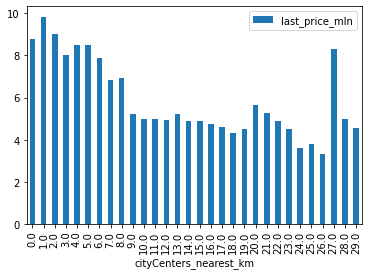

In [ ]:
good_data = data.query('locality_name_standard == "город Санкт-Петербург"').reset_index(drop=True)
good_data_pivot = good_data.groupby('cityCenters_nearest_km')[['cityCenters_nearest_km', 'last_price_mln']].median()

good_data_pivot.plot(kind='bar', x='cityCenters_nearest_km', y='last_price_mln')

In [ ]:
good_data_pivot.corr()

,cityCenters_nearest_km,last_price_mln
cityCenters_nearest_km,1.000000,-0.730346
last_price_mln,-0.730346,1.000000


In [ ]:
prev_price = 0

for i in range(len(good_data_pivot)):
    if prev_price == 0:
        prev_price = good_data_pivot.loc[i, 'last_price_mln']
        continue

    good_data_pivot.loc[i, 'last_price_mln_diff'] = good_data_pivot.loc[i, 'last_price_mln'] - prev_price
    prev_price = good_data_pivot.loc[i, 'last_price_mln']

good_data_pivot['last_price_mln_diff'].mean()


-0.14689655172413793

**Вывод**

Стоимость объекта недвижимости сильно зависит от расстояния до центра. Чем дальше объект от центра, тем дешевле.

Средняя стоимость 1 киломентра = 146 896 р.

 ### Общий вывод

Была изучена база продажи недвижимости в Санкт-Петербурге и области за период с 2014г. по 2019г.

База данных была обработана, очищена от выбросов, устранены аномалии и пропущенные значения, так же были устранены неявные дубликаты в названиях населенных пунктах.

#### Были добавлены новые столбцы для подробного анализа:

   - цена одного квадратного метра
   - год, месяц, день публикации объявления
   - тип этажа квартиры
    
#### Выводы по скорости продажи:

- Среднее кол-во дней для продажи квартиры - 94 дней
- Для недвижимости в СПб быстрыми продажами считаются продажи до 45 дней и долгими  свыше 226 дней.
- Доля долгих  продаж в СПБ значительная.
    
#### При изучении влияния параметров на цену квартиры были получены следующие выводы:

   - Общая площадь имеет самую большую положительную корреляцию. 0.75. Чем больше общая площадь квартиры тем дороже. Но из графика видно, что для сверх дорогих квартир эта корреляция пропадает. Элитное жилье это штучный товар, для которого цена устанавливается индивидуально.

   - Жилая площадь и площадь кухни так же имеют большее влияние. Это второстепенные параметры и они почти линейно коррелируются с общей площадью. Отметим, что площадь кухни имеет влияние на стоимость 1 кв м. Чем больше кухня, тем дороже 1 кв. м.

   -  Число комнат так же имеет положительную корреляцию, но для больших квартир с большим кол-вом комнат эта зависимость снижается.
Корреляция отчетливо прослеживается на стандартных квартирах до 3 комнат.

   - Год, месяц и день недели не влияют на цену. Всегда продаются квартиры из любого сегмента по стоимости.
Стоит уточнить, что стоимость 1кв м жилья имеет слабый положительный тренд к росту в зависимости от года. Каждый год стоимость 1 кв м квартиры растет.

   - Первые и последние этажи в среднем продаются дешевле, чем квартиры на других этажах
    
#### Общие выводы по стоимости 1 кв.м. в 10 населенных пунктах с наибольшим кол-вом объявлений:

- Минимальная цена 1 кв.м. в среднем начинается от 48 494 руб.
Но есть и уникальные предложения (меньше 20 тыс. руб) в разных городах (Санкт-Петербург, Гатчина, Выборг). Самая дешевая стоимость 1 кв. м. в городе Гатчина - 10 507р.

- Максимальная цена** 1 кв.в. в Санкт-Петербурге - 848 484р.
(Если взять максимальную площадь объекта в СПб = 150 кв.м., то общая стоимость составит 127.5 млн. Для квартиры в самом центре городе, для элитного жилья вполне допустимо. Конкретно в нашем случае это квартиры в центре Санкт-Петербурга, однушки с общей площадью 33 кв.м и стоимостью 28млн, что не является аномалией)

- В среднем максимальная цена 1 кв.м. по разным населенным пунктам около 147 075р

#### Выводы по стоимости каждого 1 км от центра в городе Санкт-Петербург:

- Стоимость объекта недвижимости сильно зависит от расстояния до центра. Чем дальше объект от центра, тем дешевле.

- Средняя стоимость 1 киломентра = 146 896 р.